# CNN+GRU Emotion Recognition from Audio

This notebook performs **speech emotion recognition** using a hybrid **CNN+GRU** model.
Improvements include:
- Log-Mel spectrogram features
- Data augmentation
- Class balancing via weights
- CNN+GRU architecture
- Rich evaluation (confusion matrices, classification report)
- Visualization at each stage

In [1]:
# ========== Imports ==========
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

# Optional: Focal Loss if installed
try:
    import tensorflow_addons as tfa
    focal_loss = tfa.losses.SigmoidFocalCrossEntropy()
except:
    focal_loss = None

2025-09-05 09:18:59.664411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# ========== Output Directories ==========
MODELS_DIR = "models"
IMAGES_DIR = "images"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

In [3]:
# ========== Dataset Paths ==========
ravdess = "dataset/RAVDESS"
crema = "dataset/cremad/AudioWAV"
tess = "dataset/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
savee = "dataset/surrey-audiovisual-expressed-emotion-savee/ALL/"

  Actor_01: 60 files
  Actor_02: 60 files
  Actor_03: 60 files
  Actor_04: 60 files
  Actor_05: 60 files
  Actor_06: 60 files
  Actor_07: 60 files
  Actor_08: 60 files
  Actor_09: 60 files
  Actor_10: 60 files
  Actor_11: 60 files
  Actor_12: 60 files
  Actor_13: 60 files
  Actor_14: 60 files
  Actor_15: 60 files
  Actor_16: 60 files
  Actor_17: 60 files
  Actor_18: 60 files
  Actor_19: 60 files
  Actor_20: 60 files
  Actor_21: 60 files
  Actor_22: 60 files
  Actor_23: 60 files
  Actor_24: 60 files
  audio_speech_actors_01-24: 0 files
RAVDESS: 1440 WAV files loaded from 25 actors

CREMA-D: 7442 WAV files loaded from dataset/cremad/AudioWAV

  OAF_Fear: 200 files
  OAF_Pleasant_surprise: 200 files
  OAF_Sad: 200 files
  OAF_angry: 200 files
  OAF_disgust: 200 files
  OAF_happy: 200 files
  OAF_neutral: 200 files
  YAF_angry: 200 files
  YAF_disgust: 200 files
  YAF_fear: 200 files
  YAF_happy: 200 files
  YAF_neutral: 200 files
  YAF_pleasant_surprised: 200 files
  YAF_sad: 200 files
TE

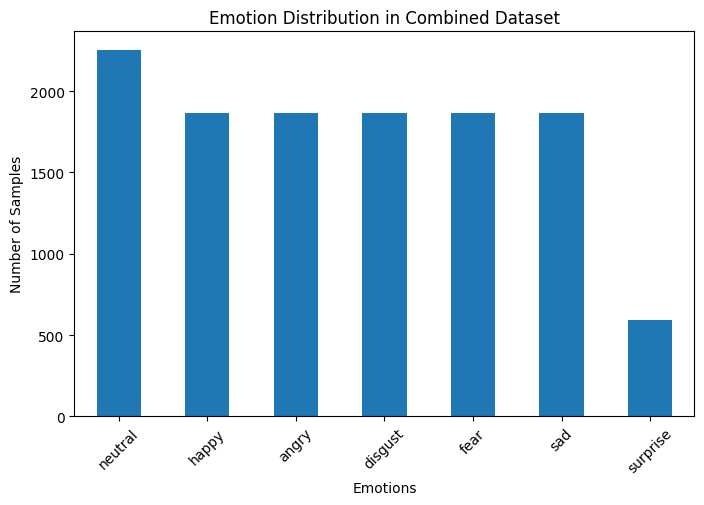

In [4]:
# ========== Load Datasets ==========
import os
import pandas as pd

# ---------- RAVDESS ----------
def load_ravdess(path):
    file_emotion, file_path = [], []
    if not os.path.exists(path):
        return pd.DataFrame()
    
    for actor in sorted(os.listdir(path)):
        actor_dir = os.path.join(path, actor)
        if not os.path.isdir(actor_dir):
            continue
        wav_files = [f for f in os.listdir(actor_dir) if f.endswith(".wav")]
        for f in wav_files:
            parts = f.split("-")
            if len(parts) < 3:
                continue
            emotion_code = int(parts[2])
            mapping = {
                1:'neutral',2:'neutral',3:'happy',4:'sad',
                5:'angry',6:'fear',7:'disgust',8:'surprise'
            }
            file_emotion.append(mapping.get(emotion_code, 'neutral'))
            file_path.append(os.path.join(actor_dir, f))
        print(f"  {actor}: {len(wav_files)} files")
    print(f"RAVDESS: {len(file_path)} WAV files loaded from {len(os.listdir(path))} actors\n")
    return pd.DataFrame({"Emotions": file_emotion, "Path": file_path})

# ---------- CREMA-D ----------
def load_crema(path):
    file_emotion, file_path = [], []
    if not os.path.exists(path):
        return pd.DataFrame()
    
    emotion_map = {'ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral','SAD':'sad'}
    wav_files = [f for f in os.listdir(path) if f.endswith(".wav")]
    for f in wav_files:
        parts = f.split('_')
        emo_code = parts[2]
        file_emotion.append(emotion_map.get(emo_code, 'neutral'))
        file_path.append(os.path.join(path, f))
    print(f"CREMA-D: {len(wav_files)} WAV files loaded from {path}\n")
    return pd.DataFrame({"Emotions": file_emotion, "Path": file_path})

# ---------- TESS ----------
def load_tess(path):
    file_emotion, file_path = [], []
    if not os.path.exists(path):
        return pd.DataFrame()
    
    emotion_map = {'angry':'angry','disgust':'disgust','fear':'fear','happy':'happy','neutral':'neutral','ps':'surprise','sad':'sad'}
    for subdir in sorted(os.listdir(path)):
        subdir_path = os.path.join(path, subdir)
        if os.path.isdir(subdir_path):
            wav_files = [f for f in os.listdir(subdir_path) if f.endswith(".wav")]
            for f in wav_files:
                emo = f.split('_')[2].split('.')[0]
                file_emotion.append(emotion_map.get(emo, 'neutral'))
                file_path.append(os.path.join(subdir_path, f))
            print(f"  {subdir}: {len(wav_files)} files")
    print(f"TESS: {len(file_path)} WAV files loaded from {len(os.listdir(path))} subfolders\n")
    return pd.DataFrame({"Emotions": file_emotion, "Path": file_path})

# ---------- SAVEE ----------
def load_savee(path):
    file_emotion, file_path = [], []
    if not os.path.exists(path):
        return pd.DataFrame()
    
    emotion_map = {'a':'angry','d':'disgust','f':'fear','h':'happy','n':'neutral','sa':'sad','su':'surprise'}
    wav_files = [f for f in os.listdir(path) if f.endswith(".wav")]
    for f in wav_files:
        emo_code = f.split('_')[1]
        file_emotion.append(emotion_map.get(emo_code, 'neutral'))
        file_path.append(os.path.join(path, f))
    print(f"SAVEE: {len(wav_files)} WAV files loaded from {path}\n")
    return pd.DataFrame({"Emotions": file_emotion, "Path": file_path})

# ---------- Load datasets ----------
ravdess_df = load_ravdess(ravdess)
crema_df = load_crema(crema)
tess_df = load_tess(tess)
savee_df = load_savee(savee)

# Combine all datasets
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0).reset_index(drop=True)
print(f"✅ Combined dataset: {len(data_path)} files\n")

# Optional: show distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
data_path["Emotions"].value_counts().plot(kind='bar')
plt.title("Emotion Distribution in Combined Dataset")
plt.xlabel("Emotions")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()


100%|██████████| 12162/12162 [38:47<00:00,  5.23it/s] 


✅ Feature array: (72972, 64, 129, 1) | Augmented samples added: 60810 | Failed: 0


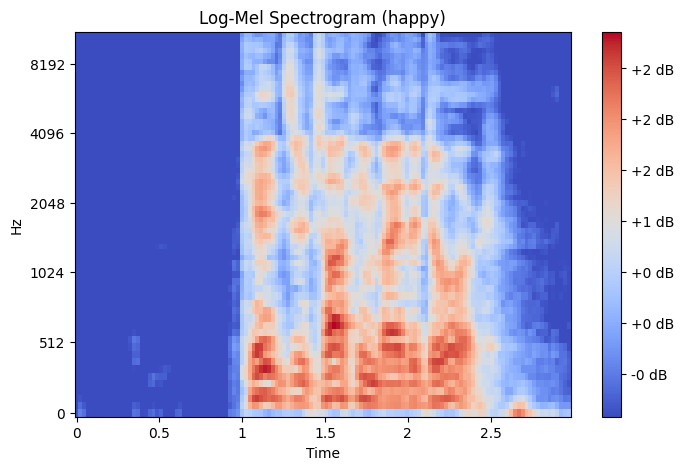

In [5]:
# %% [markdown]
# # Feature Extraction with Augmentation

# %%
# ========== Feature Extraction ==========
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

TARGET_SR = 22050  # Standard sample rate for all audio

def extract_logmel(file_path, sr=TARGET_SR, n_mels=64, max_duration=3.0, max_frames=129):
    """
    Extract normalized log-mel spectrogram from audio file.
    Pads/clips to fixed duration and frame length.

    Returns:
        np.ndarray (n_mels, max_frames, 1) or None if failed.
    """
    try:
        # Load audio at target sample rate to avoid manual resampling
        y, _ = librosa.load(file_path, sr=sr, duration=max_duration)
        
        # Skip very short files
        if len(y) < sr * 0.5:
            print(f"⚠️ Skipping very short file: {file_path}")
            return None

        # Pad or trim audio
        target_len = int(sr * max_duration)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        # Compute log-mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        logmel = librosa.power_to_db(mel)
        logmel = (logmel - np.mean(logmel)) / (np.std(logmel) + 1e-6)

        # Pad or trim frames
        if logmel.shape[1] < max_frames:
            pad_width = max_frames - logmel.shape[1]
            logmel = np.pad(logmel, ((0, 0), (0, pad_width)), mode='constant')
        else:
            logmel = logmel[:, :max_frames]

        return np.expand_dims(logmel, -1)

    except Exception as e:
        print(f"⚠️ Failed {file_path}: {e}")
        return None


def augment_audio(y, sr=TARGET_SR):
    """
    Apply audio augmentations:
    - Pitch shift ±2 semitones
    - Time stretch 0.9x / 1.1x
    - Add Gaussian noise
    Clips audio to [-1, 1].
    """
    augmented = [
        librosa.effects.pitch_shift(y, sr=sr, n_steps=2),
        librosa.effects.pitch_shift(y, sr=sr, n_steps=-2),
        librosa.effects.time_stretch(y, rate=0.9),
        librosa.effects.time_stretch(y, rate=1.1),
        y + 0.005 * np.random.randn(len(y))
    ]
    return [np.clip(a, -1.0, 1.0) for a in augmented]


def extract_logmel_from_array(y, sr=TARGET_SR, n_mels=64, max_duration=3.0, max_frames=129):
    """
    Extract log-mel spectrogram from raw audio array.
    """
    try:
        target_len = int(sr * max_duration)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        logmel = librosa.power_to_db(mel)
        logmel = (logmel - np.mean(logmel)) / (np.std(logmel) + 1e-6)

        if logmel.shape[1] < max_frames:
            pad_width = max_frames - logmel.shape[1]
            logmel = np.pad(logmel, ((0, 0), (0, pad_width)), mode='constant')
        else:
            logmel = logmel[:, :max_frames]

        return np.expand_dims(logmel, -1)
    except Exception as e:
        print(f"⚠️ Augment failed: {e}")
        return None


# ========== Extract features for entire dataset ==========
X, y, failed = [], [], []
aug_count = 0

for row in tqdm(data_path.itertuples(), total=len(data_path)):
    feat = extract_logmel(row.Path, sr=TARGET_SR)
    if feat is not None:
        X.append(feat)
        y.append(row.Emotions)

        # Load audio directly at target sample rate
        y_raw, _ = librosa.load(row.Path, sr=TARGET_SR, duration=3.0)
        for y_aug in augment_audio(y_raw, TARGET_SR):
            aug_feat = extract_logmel_from_array(y_aug, sr=TARGET_SR, n_mels=64, max_frames=129)
            if aug_feat is not None:
                X.append(aug_feat)
                y.append(row.Emotions)
                aug_count += 1
    else:
        failed.append(row.Path)

X = np.array(X)
y = np.array(y)
print(f"✅ Feature array: {X.shape} | Augmented samples added: {aug_count} | Failed: {len(failed)}")


# ========== Example Spectrogram ==========
example_path = data_path.iloc[0].Path
logmel_example = extract_logmel(example_path, sr=TARGET_SR)
plt.figure(figsize=(8, 5))
librosa.display.specshow(logmel_example.squeeze(), sr=TARGET_SR, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title(f"Log-Mel Spectrogram ({data_path.iloc[0].Emotions})")
plt.show()


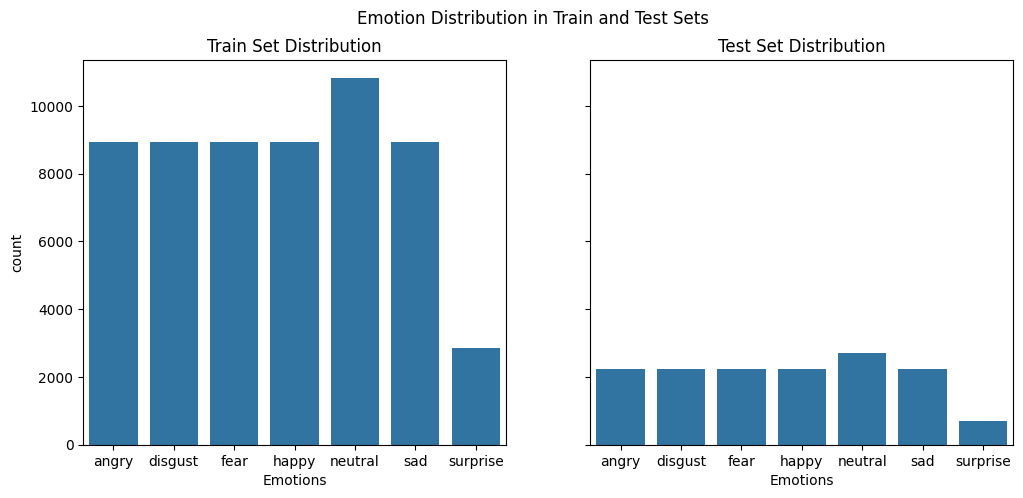

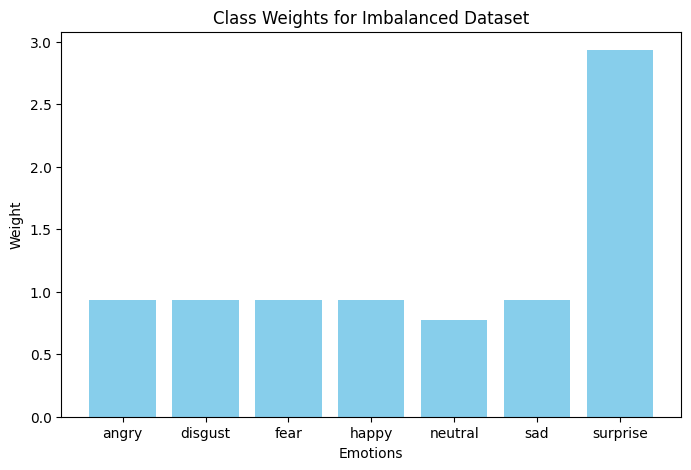

In [6]:
# ========== Preprocessing ==========
from sklearn.utils.class_weight import compute_class_weight

# Encode emotion labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  # Integer labels
y_onehot = tf.keras.utils.to_categorical(y_enc)  # One-hot for training

# Split dataset into train/test sets (stratified by label)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_enc,  # Preserve class distribution
    shuffle=True
)

# Compute class weights based on training labels (balanced)
train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Plot train/test label distributions
train_label_names = le.inverse_transform(np.argmax(y_train, axis=1))
test_label_names = le.inverse_transform(np.argmax(y_test, axis=1))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.countplot(x=train_label_names, order=le.classes_, ax=axes[0])
axes[0].set_title("Train Set Distribution")
axes[0].set_xlabel("Emotions")
sns.countplot(x=test_label_names, order=le.classes_, ax=axes[1])
axes[1].set_title("Test Set Distribution")
axes[1].set_xlabel("Emotions")
plt.suptitle("Emotion Distribution in Train and Test Sets")
plt.show()

# Plot computed class weights
plt.figure(figsize=(8, 5))
plt.bar(le.classes_, class_weights, color='skyblue')
plt.title("Class Weights for Imbalanced Dataset")
plt.xlabel("Emotions")
plt.ylabel("Weight")
plt.show()


In [7]:
# ========== Model ==========
def create_cnn_gru(input_shape, num_classes):
    """
    Build CNN+GRU hybrid model for speech emotion recognition.
    """
    inputs = layers.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)  # added

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)  # added

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # GRU sequence
    x = layers.RepeatVector(20)(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=False))(x)
    x = layers.Dropout(0.4)(x)

    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4),
        loss=focal_loss if focal_loss else 'categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_cnn_gru(X_train.shape[1:], y_onehot.shape[1])
model.summary()


2025-09-05 09:57:56.220123: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-09-05 09:57:56.220331: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-09-05 09:57:56.220341: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: WORK
2025-09-05 09:57:56.220345: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: WORK
2025-09-05 09:57:56.220507: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 560.35.3
2025-09-05 09:57:56.220539: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:194] kernel reported version is: 560.35.3
2025-09-05 09

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 129, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 129, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 129, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,511 (1.12 MB)

 Trainable params: 293,063 (1.12 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/80


2025-09-05 09:58:08.142773: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1542253824 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from None to 0.50317, saving model to models/best_model.keras
1460/1460 - 385s - 264ms/step - accuracy: 0.4950 - loss: 1.2199 - val_accuracy: 0.5032 - val_loss: 1.3914 - learning_rate: 3.0000e-04
Epoch 2/80

Epoch 2: val_accuracy improved from 0.50317 to 0.55096, saving model to models/best_model.keras
1460/1460 - 346s - 237ms/step - accuracy: 0.6136 - loss: 0.9307 - val_accuracy: 0.5510 - val_loss: 1.2533 - learning_rate: 3.0000e-04
Epoch 3/80

Epoch 3: val_accuracy did not improve from 0.55096
1460/1460 - 394s - 270ms/step - accuracy: 0.6459 - loss: 0.8495 - val_accuracy: 0.4466 - val_loss: 1.8759 - learning_rate: 3.0000e-04
Epoch 4/80

Epoch 4: val_accuracy improved from 0.55096 to 0.59618, saving model to models/best_model.keras
1460/1460 - 362s - 248ms/step - accuracy: 0.6668 - loss: 0.8027 - val_accuracy: 0.5962 - val_loss: 1.1157 - learning_rate: 3.0000e-04
Epoch 5/80

Epoch 5: val_accuracy improved from 0.59618 to 0.66727, saving model to models/

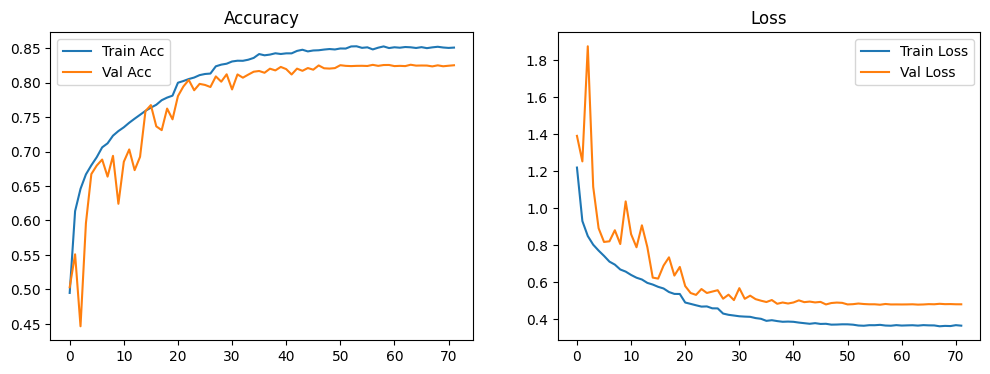

In [8]:
# ========== Training ==========
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    ModelCheckpoint(os.path.join(MODELS_DIR, 'best_model.keras'), monitor='val_accuracy', save_best_only=True, verbose=1),
    TensorBoard(log_dir="logs")
]

# Fit model
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=2
)

# Training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step
✅ Test Accuracy: 81.87%
F1 (macro): 0.8334071594816603
              precision    recall  f1-score   support

       angry       0.89      0.88      0.88      2236
     disgust       0.80      0.77      0.79      2235
        fear       0.81      0.73      0.77      2236
       happy       0.88      0.78      0.82      2236
     neutral       0.84      0.88      0.86      2706
         sad       0.68      0.80      0.73      2236
    surprise       0.97      0.99      0.98       710

    accuracy                           0.82     14595
   macro avg       0.84      0.83      0.83     14595
weighted avg       0.82      0.82      0.82     14595



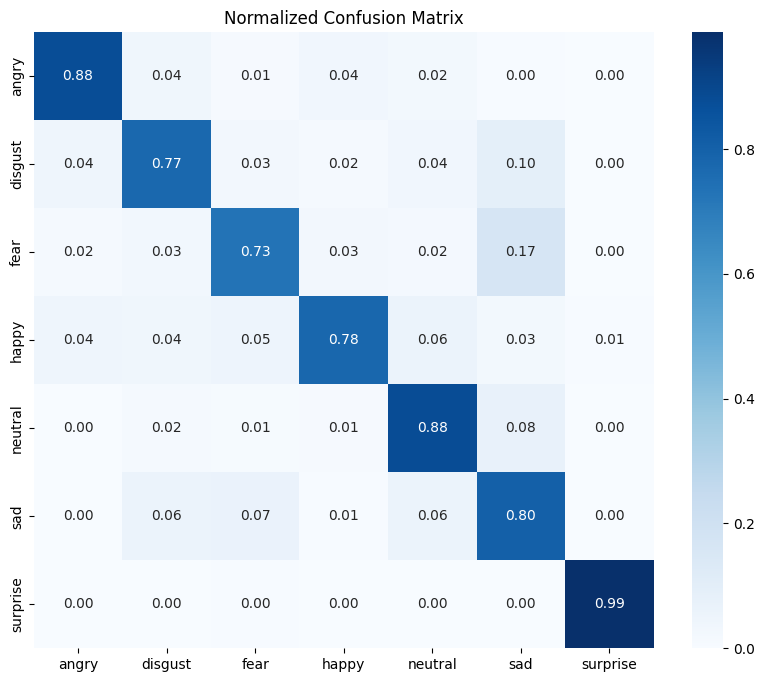

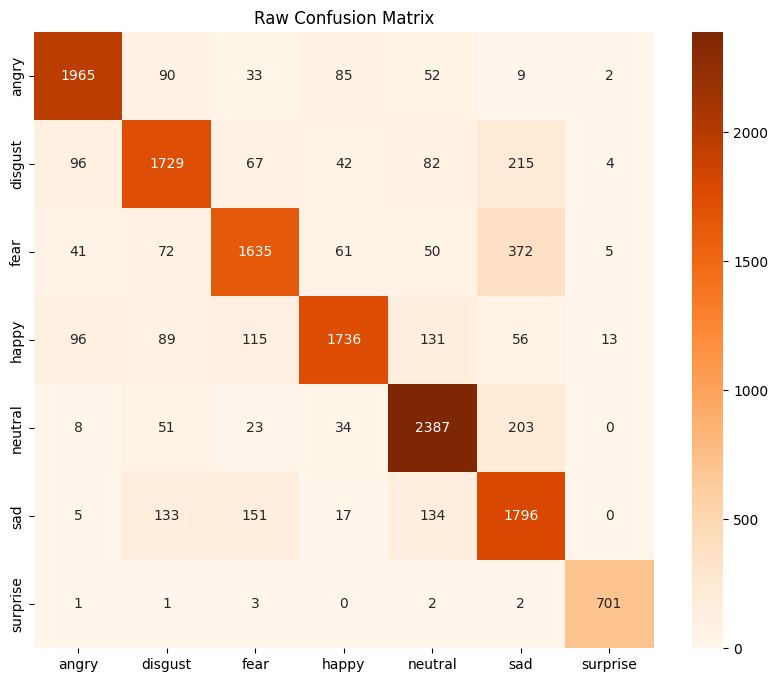

angry: Precision=0.89, Recall=0.88, F1=0.88, Support=2236
disgust: Precision=0.80, Recall=0.77, F1=0.79, Support=2235
fear: Precision=0.81, Recall=0.73, F1=0.77, Support=2236
happy: Precision=0.88, Recall=0.78, F1=0.82, Support=2236
neutral: Precision=0.84, Recall=0.88, F1=0.86, Support=2706
sad: Precision=0.68, Recall=0.80, F1=0.73, Support=2236
surprise: Precision=0.97, Recall=0.99, F1=0.98, Support=710


In [9]:
# Predictions with batch_size
from sklearn.metrics import precision_recall_fscore_support


y_pred = model.predict(X_test, batch_size=64) 
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Accuracy & F1
acc = accuracy_score(y_true_classes, y_pred_classes)
print(f"✅ Test Accuracy: {acc*100:.2f}%")
print("F1 (macro):", f1_score(y_true_classes, y_pred_classes, average='macro'))
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Confusion matrix (normalized)
cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix")
plt.show()

# Optional: raw confusion matrix
cm_raw = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm_raw, annot=True, fmt="d", cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Raw Confusion Matrix")
plt.show()

# Optional: per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)
for i, cls in enumerate(le.classes_):
    print(f"{cls}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1={f1[i]:.2f}, Support={support[i]}")


In [12]:
# ========== Save Model ==========
model.save(os.path.join(MODELS_DIR,'final_emotion_model.keras'))
with open(os.path.join(MODELS_DIR,'label_encoder.pkl'),'wb') as f:
    pickle.dump(le,f)

In [21]:
# Load trained model and label encoder
loaded_model = tf.keras.models.load_model(os.path.join(MODELS_DIR,'final_emotion_model.keras'))
with open(os.path.join(MODELS_DIR,'label_encoder.pkl'),'rb') as f:
    loaded_le = pickle.load(f)

def predict_emotion(audio_path):
    """
    Predict emotion from an audio file path using trained model.
    """
    try:
        # Extract log-mel features at training sample rate
        feat = extract_logmel(audio_path, sr=22050)
        if feat is None:
            return None
        feat = np.expand_dims(feat, axis=0)
        pred = loaded_model.predict(feat, verbose=0)
        pred_class = np.argmax(pred, axis=1)[0]
        return loaded_le.inverse_transform([pred_class])[0]
    except Exception as e:
        print(f"⚠️ Prediction failed: {e}")
        return None

# Example prediction
example_path = "dataset/cremad/AudioWAV/1001_IWW_HAP_XX.wav"
print(predict_emotion(example_path))


happy
